In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms

import helper

In [2]:
data_dir = '/home/akshay/Downloads/Flower Classification'
batch_size = 32
tf = transforms.Compose([transforms.Resize((255, 255)),
                         transforms.ToTensor(),
                        ])

train_dataset = datasets.ImageFolder(data_dir, transform = tf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

torch.Size([32, 3, 255, 255])
torch.Size([32])


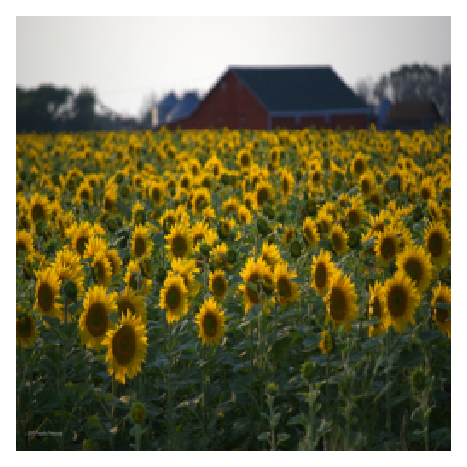

In [3]:
images, labels = next(iter(train_loader))
print(images.shape)
helper.imshow(images[0], normalize = False)
print(labels.shape)

In [4]:
a = images.view(images.shape[0], -1)
print(a.shape)

torch.Size([32, 195075])


In [14]:
m = len(train_loader) * batch_size
n = 255 * 255 * 3
learning_rate = 1e-3
W = torch.randn(n, 1).float()
b = torch.randn(1, 1).float()

In [4]:
def binary_cross_entropy(A, Y):
    loss = -(1 / m) * (torch.dot(Y, A) + torch.dot((1 - Y), (1 - A)))
    return loss

In [5]:
def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

In [6]:
def forward(x):
    out = torch.matmul(W.t(), x) + b
    out = sigmoid(out)
    # size - (1, batch_size)
    return out

In [17]:
# Training Loop
for i in range(20):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
#         if use_cuda:
#             images = images.cuda()
#             labels = labels.cuda()
#             W = W.cuda()
#             b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
#         print(images.shape)
#         print(W.shape)
#         print('Images and labels modified as required')
        pred = forward(images)
#         print('Forward propagation done')
#         _, index_pred = torch.max(pred, 0)
        
        loss = binary_cross_entropy(pred.resize_(pred.shape[1]), labels)
        epoch_loss += loss.item()
#         print('Current loss calculated')
        dz = pred - labels.resize_(labels.shape[0])
#         print(dz.shape)
#         print(images.shape)
        dw = (1 / m) * torch.matmul(dz, images.t())
#         print(dw.shape)
        db = (1 / m) * torch.sum(dz)
#         print(db.shape)
#         print('back prop done')
        dw2 = learning_rate * dw
#         print(dw2.shape)
#         print(W.shape)
        W -= dw2.resize_(dw2.shape[0], 1)
        b -= (learning_rate * db)
#         print('Loss at step ', batch_idx, ' = ', epoch_loss)

    epoch_loss /= m
    print('Loss at epoch', i, ' = ', epoch_loss)

Loss at epoch 0  =  -0.0003577141754001125
Loss at epoch 1  =  -0.00035358853446351446
Loss at epoch 2  =  -0.0003547073062112428
Loss at epoch 3  =  -0.00035860022630500185
Loss at epoch 4  =  -0.0003502909593490503
Loss at epoch 5  =  -0.0003604408970700619
Loss at epoch 6  =  -0.00034867919335242317
Loss at epoch 7  =  -0.0003494929925099396
Loss at epoch 8  =  -0.0003517705154081341
Loss at epoch 9  =  -0.00035632473141462964
Loss at epoch 10  =  -0.0003548490342588841
Loss at epoch 11  =  -0.0003561817829904612
Loss at epoch 12  =  -0.00034121970020351
Loss at epoch 13  =  -0.0003524506391840987
Loss at epoch 14  =  -0.00033888084643959616
Loss at epoch 15  =  -0.0003554586860859259
Loss at epoch 16  =  -0.0003606682902583006
Loss at epoch 17  =  -0.00036746756615519354
Loss at epoch 18  =  -0.00034712419073912315
Loss at epoch 19  =  -0.0003642946956626309


In [124]:
a = torch.randn((2, 3))
print(a)

tensor([[ 1.0537, -0.1413, -1.7341],
        [ 1.7875,  0.5772, -0.5618]])


In [125]:
b = torch.transpose(a, 1, 0)
print(b)

tensor([[ 1.0537,  1.7875],
        [-0.1413,  0.5772],
        [-1.7341, -0.5618]])
